<a href="https://colab.research.google.com/github/siren7075/TradingAgentRL/blob/main/TradingAgentFinRl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1. Install and LoadPackages

In [ ]:
#12min
!pip install git+https://github.com/benstaf/FinRL.git
!pip install selenium webdriver-manager alpaca-py datasets
!git clone https://github.com/benstaf/FinRL_DeepSeek.git
%cd FinRL_DeepSeek
!bash installation_script.sh
!pip install transformers datasets huggingface_hub stable-baselines3

In [ ]:
from huggingface_hub import snapshot_download
import shutil

# Download the entire repo
local_dir = snapshot_download(repo_id="benstaf/Trading_agents")

# Optional: move all files to root /content
shutil.copytree(local_dir, "/content", dirs_exist_ok=True)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3

#from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.config import INDICATORS, TRAINED_MODEL_DIR
from env_stocktrading import StockTradingEnv


# Import PPO-DeepSeek environments
from env_stocktrading_llm import StockTradingEnv as StockTradingEnv_llm
from env_stocktrading_llm_1 import StockTradingEnv as StockTradingEnv_llm_1
from env_stocktrading_llm_01 import StockTradingEnv as StockTradingEnv_llm_01

# Import CPPO-DeepSeek risk environments
from env_stocktrading_llm_risk import StockTradingEnv as StockTradingEnv_llm_risk
from env_stocktrading_llm_risk_1 import StockTradingEnv as StockTradingEnv_llm_risk_1
from env_stocktrading_llm_risk_01 import StockTradingEnv as StockTradingEnv_llm_risk_01

#from env_stocktrading_llm import StockTradingEnv as StockTradingEnv_llm

#from env_stocktrading_llm_risk import StockTradingEnv as StockTradingEnv_llm_risk


#from finrl.meta.env_stock_trading.env_stocktrading_llm import StockTradingEnv
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader


from datasets import load_dataset

%matplotlib inline

# Part 2. Prepare for Models

In [ ]:
# from Huggging Face :
dataset = load_dataset("benstaf/nasdaq_2013_2023", data_files='trade_data_deepseek_sentiment_2019_2023.csv')

# Convert to pandas DataFrame
trade = pd.DataFrame(dataset['train'])

#trade= pd.read_csv('/content/machine_learning/trade_data_qwen_sentiment.csv')

trade = trade.drop('Unnamed: 0',axis=1)

# Create a new index based on unique dates
unique_dates = trade['date'].unique()
date_to_idx = {date: idx for idx, date in enumerate(unique_dates)}

# Create new index based on the date mapping
trade['new_idx'] = trade['date'].map(date_to_idx)

# Set this as the index
trade = trade.set_index('new_idx')


#missing values with 0
trade['llm_sentiment'].fillna(0, inplace=True)
trade_llm=trade


#trade = pd.read_csv('/content/machine_learning/trade_data_qwen_risk.csv')

# from Huggging Face :
dataset = load_dataset("benstaf/nasdaq_2013_2023", data_files='trade_data_deepseek_risk_2019_2023.csv')

# Convert to pandas DataFrame
trade = pd.DataFrame(dataset['train'])

trade = trade.drop('Unnamed: 0',axis=1)

# Create a new index based on unique dates
unique_dates = trade['date'].unique()
date_to_idx = {date: idx for idx, date in enumerate(unique_dates)}

# Create new index based on the date mapping
trade['new_idx'] = trade['date'].map(date_to_idx)

# Set this as the index
trade = trade.set_index('new_idx')


#missing values with 0
trade['llm_sentiment'].fillna(0, inplace=True)
#missing values with 3
trade['llm_risk'].fillna(3, inplace=True)
trade_llm_risk=trade

#trade = pd.read_csv('/content/machine_learning/trade_data_qwen_risk.csv')

# from Huggging Face :
dataset = load_dataset("benstaf/nasdaq_2013_2023", data_files='trade_data_2019_2023.csv')

# Convert to pandas DataFrame
trade = pd.DataFrame(dataset['train'])

trade = trade.drop('Unnamed: 0',axis=1)

# Create a new index based on unique dates
unique_dates = trade['date'].unique()
date_to_idx = {date: idx for idx, date in enumerate(unique_dates)}

# Create new index based on the date mapping
trade['new_idx'] = trade['date'].map(date_to_idx)

# Set this as the index
trade = trade.set_index('new_idx')



In [ ]:
stock_dimension = len(trade.tic.unique())
state_space = 1 + 2 * stock_dimension + len(INDICATORS) * stock_dimension #+ stock_dimension # +LLM sentiment
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

stock_dimension_llm = len(trade_llm.tic.unique())
state_space_llm = 1 + 2 * stock_dimension_llm + (1+len(INDICATORS)) * stock_dimension_llm #+ stock_dimension # +LLM sentiment
print(f"Stock Dimension: {stock_dimension_llm}, State Space: {state_space_llm}")

stock_dimension = len(trade.tic.unique())
state_space_llm_risk = 1 + 2 * stock_dimension + (2+len(INDICATORS)) * stock_dimension #+ stock_dimension # +LLM sentiment + LLM risk
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space_llm_risk}")

buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

buy_cost_list_llm = sell_cost_list_llm = [0.001] * stock_dimension_llm
num_stock_shares_llm = [0] * stock_dimension_llm

env_kwargs_llm = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares_llm,
    "buy_cost_pct": buy_cost_list_llm,
    "sell_cost_pct": sell_cost_list_llm,
    "state_space": state_space_llm,
    "stock_dim": stock_dimension_llm,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension_llm,
    "reward_scaling": 1e-4
}

buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs_llm_risk = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space_llm_risk,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

e_trade_llm_gym = StockTradingEnv_llm(df = trade_llm, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs_llm)
# env_trade, obs_trade = e_trade_gym.get_sb_env()


# Environment for PPO-DeepSeek 10%
e_trade_llm_gym = StockTradingEnv_llm(df=trade_llm, turbulence_threshold=70, risk_indicator_col='vix', **env_kwargs_llm)

# Environment for PPO-DeepSeek 1%
e_trade_llm_gym_1 = StockTradingEnv_llm_1(df=trade_llm, turbulence_threshold=70, risk_indicator_col='vix', **env_kwargs_llm)

# Environment for PPO-DeepSeek 0.1%
e_trade_llm_gym_01 = StockTradingEnv_llm_01(df=trade_llm, turbulence_threshold=70, risk_indicator_col='vix', **env_kwargs_llm)

e_trade_llm_risk_gym = StockTradingEnv_llm_risk(df = trade_llm_risk, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs_llm_risk)

# Environment for CPPO-DeepSeek 10% risk
e_trade_llm_risk_gym = StockTradingEnv_llm_risk(df=trade_llm_risk, turbulence_threshold=70, risk_indicator_col='vix', **env_kwargs_llm_risk)

# Environment for CPPO-DeepSeek 1% risk
e_trade_llm_risk_gym_1 = StockTradingEnv_llm_risk_1(df=trade_llm_risk, turbulence_threshold=70, risk_indicator_col='vix', **env_kwargs_llm_risk)

# Environment for CPPO-DeepSeek 0.1% risk
e_trade_llm_risk_gym_01 = StockTradingEnv_llm_risk_01(df=trade_llm_risk, turbulence_threshold=70, risk_indicator_col='vix', **env_kwargs_llm_risk)

observation_space=e_trade_gym.observation_space
action_space=e_trade_gym.action_space

observation_space_llm=e_trade_llm_gym.observation_space
action_space_llm=e_trade_llm_gym.action_space

observation_space_llm_risk=e_trade_llm_risk_gym.observation_space
action_space_llm_risk=e_trade_llm_risk_gym.action_space

# Observation and action spaces for PPO-DeepSeek 10%
observation_space_llm = e_trade_llm_gym.observation_space
action_space_llm = e_trade_llm_gym.action_space

# Observation and action spaces for PPO-DeepSeek 1%
observation_space_llm_1 = e_trade_llm_gym_1.observation_space
action_space_llm_1 = e_trade_llm_gym_1.action_space

# Observation and action spaces for PPO-DeepSeek 0.1%
observation_space_llm_01 = e_trade_llm_gym_01.observation_space
action_space_llm_01 = e_trade_llm_gym_01.action_space

# Observation and action spaces for CPPO-DeepSeek 10% risk
observation_space_llm_risk = e_trade_llm_risk_gym.observation_space
action_space_llm_risk = e_trade_llm_risk_gym.action_space

# Observation and action spaces for CPPO-DeepSeek 1% risk
observation_space_llm_risk_1 = e_trade_llm_risk_gym_1.observation_space
action_space_llm_risk_1 = e_trade_llm_risk_gym_1.action_space

# Observation and action spaces for CPPO-DeepSeek 0.1% risk
observation_space_llm_risk_01 = e_trade_llm_risk_gym_01.observation_space
action_space_llm_risk_01 = e_trade_llm_risk_gym_01.action_space

print("State shape:", observation_space_llm.shape)


import numpy as np
import scipy.signal
from gymnasium.spaces import Box, Discrete

import torch
import torch.nn as nn
from torch.distributions.normal import Normal
from torch.distributions.categorical import Categorical


def combined_shape(length, shape=None):
    if shape is None:
        return (length,)
    return (length, shape) if np.isscalar(shape) else (length, *shape)


def mlp(sizes, activation, output_activation=nn.Identity):
    layers = []
    for j in range(len(sizes)-1):
        act = activation if j < len(sizes)-2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j+1]), act()]
    return nn.Sequential(*layers)


def count_vars(module):
    return sum([np.prod(p.shape) for p in module.parameters()])


def discount_cumsum(x, discount):
    """
    magic from rllab for computing discounted cumulative sums of vectors.

    input:
        vector x,
        [x0,
         x1,
         x2]

    output:
        [x0 + discount * x1 + discount^2 * x2,
         x1 + discount * x2,
         x2]
    """
    return scipy.signal.lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]


class Actor(nn.Module):

    def _distribution(self, obs):
        raise NotImplementedError

    def _log_prob_from_distribution(self, pi, act):
        raise NotImplementedError

    def forward(self, obs, act=None):
        # Produce action distributions for given observations, and
        # optionally compute the log likelihood of given actions under
        # those distributions.
        pi = self._distribution(obs)
        logp_a = None
        if act is not None:
            logp_a = self._log_prob_from_distribution(pi, act)
        return pi, logp_a


class MLPCategoricalActor(Actor):

    def __init__(self, obs_dim, act_dim, hidden_sizes, activation):
        super().__init__()
        self.logits_net = mlp([obs_dim] + list(hidden_sizes) + [act_dim], activation)

    def _distribution(self, obs):
        logits = self.logits_net(obs)
        return Categorical(logits=logits)

    def _log_prob_from_distribution(self, pi, act):
        return pi.log_prob(act)


class MLPGaussianActor(Actor):

    def __init__(self, obs_dim, act_dim, hidden_sizes, activation):
        super().__init__()
        log_std = -0.5 * np.ones(act_dim, dtype=np.float32)
        self.log_std = torch.nn.Parameter(torch.as_tensor(log_std))
        self.mu_net = mlp([obs_dim] + list(hidden_sizes) + [act_dim], activation)

    def _distribution(self, obs):
        mu = self.mu_net(obs)
        std = torch.exp(self.log_std)
        return Normal(mu, std)

    def _log_prob_from_distribution(self, pi, act):
        return pi.log_prob(act).sum(axis=-1)    # Last axis sum needed for Torch Normal distribution


class MLPCritic(nn.Module):

    def __init__(self, obs_dim, hidden_sizes, activation):
        super().__init__()
        self.v_net = mlp([obs_dim] + list(hidden_sizes) + [1], activation)

    def forward(self, obs):
        return torch.squeeze(self.v_net(obs), -1) # Critical to ensure v has right shape.



class MLPActorCritic(nn.Module):
    def __init__(self, observation_space, action_space,
                 hidden_sizes=(64, 64), activation=nn.Tanh):
        super().__init__()

        obs_dim = observation_space.shape[0]

        # policy builder depends on action space
        if isinstance(action_space, Box):
            self.pi = MLPGaussianActor(obs_dim, action_space.shape[0], hidden_sizes, activation)
        elif isinstance(action_space, Discrete):
            self.pi = MLPCategoricalActor(obs_dim, action_space.n, hidden_sizes, activation)

        # build value function
        self.v = MLPCritic(obs_dim, hidden_sizes, activation)

    def step(self, obs):
        with torch.no_grad():
            pi = self.pi._distribution(obs)
            a = pi.sample()
            logp_a = self.pi._log_prob_from_distribution(pi, a)
            v = self.v(obs)
        return a.numpy(), v.numpy(), logp_a.numpy()

    def act(self, obs):
        return self.step(obs)[0]

!dir

In [ ]:
# Load the model
loaded_ppo = MLPActorCritic(observation_space,action_space, hidden_sizes=(512, 512))
print (loaded_ppo)
loaded_ppo.load_state_dict(torch.load('/content/agent_ppo_100_epochs_20k_steps.pth'))
#loaded_ppo.load_state_dict(torch.load('//content/agent_ppo_100_epochs_20k_steps.pth'))

loaded_ppo.eval()  # Set the model to evaluation mode

# Load the model
loaded_cppo = MLPActorCritic(observation_space,action_space, hidden_sizes=(512, 512))
loaded_cppo.load_state_dict(torch.load('/content/agent_cppo_100_epochs_20k_steps.pth'))
#loaded_ppo.load_state_dict(torch.load('/kaggle/input/agent_cppo_25_epochs_20k_steps/pytorch/default/1/agent_ppo_25_epochs_20k_steps.pth'))

loaded_cppo.eval()  # Set the model to evaluation mode

# Load the model
loaded_ppo_llm = MLPActorCritic(observation_space_llm,action_space_llm, hidden_sizes=(512, 512))
loaded_ppo_llm.load_state_dict(torch.load('/content/FinRL_LLM/trained_models/agent_ppo_deepseek_100_epochs_20k_steps.pth'))
#loaded_ppo_llm.load_state_dict(torch.load('/kaggle/input/agent_cppo_25_epochs_20k_steps/pytorch/default/1/agent_ppo_25_epochs_20k_steps.pth'))

loaded_ppo_llm.eval()  # Set the model to evaluation mode

# Load the model
loaded_ppo_llama = MLPActorCritic(observation_space_llm,action_space_llm, hidden_sizes=(512, 512))
loaded_ppo_llama.load_state_dict(torch.load('/content/agent_ppo_llama_100_epochs_20k_steps.pth'))

loaded_ppo_llm.eval()  # Set the model to evaluation mode

# Load the model
loaded_cppo_llm_risk = MLPActorCritic(observation_space_llm_risk,action_space_llm_risk, hidden_sizes=(512, 512))
loaded_cppo_llm_risk.load_state_dict(torch.load('/content/agent_cppo_deepseek_100_epochs_20k_steps.pth'))

loaded_cppo_llm_risk.eval()  # Set the model to evaluation mode

# Load the PPO-DeepSeek 10% model
loaded_ppo_llm = MLPActorCritic(observation_space_llm, action_space_llm, hidden_sizes=(512, 512))
loaded_ppo_llm.load_state_dict(torch.load('/content/agent_ppo_deepseek_100_epochs_20k_steps.pth'))
loaded_ppo_llm.eval()  # Set the model to evaluation mode


# Load the PPO-DeepSeek 1% model
loaded_ppo_llm_1 = MLPActorCritic(observation_space_llm_1, action_space_llm_1, hidden_sizes=(512, 512))
loaded_ppo_llm_1.load_state_dict(torch.load('/content/agent_ppo_deepseek_100_epochs_20k_steps_1.pth'))
loaded_ppo_llm_1.eval()

# Load the PPO-DeepSeek 0.1% model
loaded_ppo_llm_01 = MLPActorCritic(observation_space_llm_01, action_space_llm_01, hidden_sizes=(512, 512))
loaded_ppo_llm_01.load_state_dict(torch.load('/content/agent_ppo_deepseek_100_epochs_20k_steps_01.pth'))
loaded_ppo_llm_01.eval()

# Load the CPPO-DeepSeek 10% risk model
loaded_cppo_llm_risk = MLPActorCritic(observation_space_llm_risk, action_space_llm_risk, hidden_sizes=(512, 512))
loaded_cppo_llm_risk.load_state_dict(torch.load('/content/agent_cppo_deepseek_100_epochs_20k_steps.pth'))
loaded_cppo_llm_risk.eval()

# Load the CPPO-DeepSeek 1% risk model
loaded_cppo_llm_risk_1 = MLPActorCritic(observation_space_llm_risk_1, action_space_llm_risk_1, hidden_sizes=(512, 512))
loaded_cppo_llm_risk_1.load_state_dict(torch.load('/content/agent_cppo_deepseek_100_epochs_20k_steps_1.pth'))
loaded_cppo_llm_risk_1.eval()

# Load the CPPO-DeepSeek 0.1% risk model
loaded_cppo_llm_risk_01 = MLPActorCritic(observation_space_llm_risk_01, action_space_llm_risk_01, hidden_sizes=(512, 512))
loaded_cppo_llm_risk_01.load_state_dict(torch.load('/content/agent_cppo_deepseek_100_epochs_20k_steps_01.pth'))
loaded_cppo_llm_risk_01.eval()

# Load the model
loaded_cppo_llama_risk = MLPActorCritic(observation_space_llm_risk,action_space_llm_risk, hidden_sizes=(512, 512))
loaded_cppo_llama_risk.load_state_dict(torch.load('/content/agent_deepseek_20_epochs_20k_steps.pth'))

loaded_cppo_llama_risk.eval()  # Set the model to evaluation mode

In [ ]:

def DRL_prediction(act, environment):
    import torch
    _torch = torch

    state, _ = environment.reset()
    account_memory = []  # To store portfolio values
    actions_memory = []  # To store actions taken
    portfolio_distribution = []  # To store portfolio distribution
    episode_total_assets = [environment.initial_amount]

    with _torch.no_grad():
        for i in range(len(environment.df.index.unique())):
            s_tensor = _torch.as_tensor((state,), dtype=torch.float32, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
            a_tensor, _, _ = act.step(s_tensor)  # Compute action
            action = a_tensor[0]  # Extract action

            # Step through the environment
            state, reward, done, _, _ = environment.step(action)

            # Get stock prices for the current day
            price_array = environment.df.loc[environment.day, "close"].values

            # Stock holdings and cash balance
            stock_holdings = environment.num_stock_shares
            cash_balance = environment.asset_memory[-1]

            # Calculate total portfolio value
            total_asset = cash_balance + (price_array * stock_holdings).sum()

            # Calculate portfolio distribution
            stock_values = price_array * stock_holdings
            total_invested = stock_values.sum()
            distribution = stock_values / total_asset  # Fraction of each stock in the total portfolio
            cash_fraction = cash_balance / total_asset

            # Store results
            episode_total_assets.append(total_asset)
            account_memory.append(total_asset)
            actions_memory.append(action)
            portfolio_distribution.append({"cash": cash_fraction, "stocks": distribution.tolist()})

       #     print("Total Asset Value:", total_asset)
        #    print("Portfolio Distribution:", {"cash": cash_fraction, "stocks": distribution.tolist()})

            if done:
                break

    print("Test Finished!")
    return episode_total_assets, account_memory, actions_memory, portfolio_distribution

In [ ]:
df_assets_ppo, df_account_value_ppo, df_actions_ppo, df_portfolio_distribution_ppo = DRL_prediction(act=loaded_ppo, environment=e_trade_gym)
#episode_total_assets, account_memory, actions_memory, portfolio_distribution = DRL_prediction(act=loaded_ppo, environment=e_trade_gym)

df_assets_cppo, df_account_value_cppo, df_actions_cppo, df_portfolio_distribution_cppo = DRL_prediction(act=loaded_cppo, environment=e_trade_gym)

# Prediction for PPO-DeepSeek 10%
df_assets_ppo_llm, df_account_value_ppo_llm, df_actions_ppo_llm, df_portfolio_distribution_ppo_llm = DRL_prediction(
    act=loaded_ppo_llm, environment=e_trade_llm_gym
)

# Prediction for PPO-DeepSeek 1%
df_assets_ppo_llm_1, df_account_value_ppo_llm_1, df_actions_ppo_llm_1, df_portfolio_distribution_ppo_llm_1 = DRL_prediction(
    act=loaded_ppo_llm_1, environment=e_trade_llm_gym_1
)

# Prediction for PPO-DeepSeek 0.1%
df_assets_ppo_llm_01, df_account_value_ppo_llm_01, df_actions_ppo_llm_01, df_portfolio_distribution_ppo_llm_01 = DRL_prediction(
    act=loaded_ppo_llm_01, environment=e_trade_llm_gym_01
)

# Prediction for CPPO-DeepSeek 10% risk
df_assets_cppo_llm_risk, df_account_value_cppo_llm_risk, df_actions_cppo_llm_risk, df_portfolio_distribution_cppo_llm_risk = DRL_prediction(
    act=loaded_cppo_llm_risk, environment=e_trade_llm_risk_gym
)

# Prediction for CPPO-DeepSeek 1% risk
df_assets_cppo_llm_risk_1, df_account_value_cppo_llm_risk_1, df_actions_cppo_llm_risk_1, df_portfolio_distribution_cppo_llm_risk_1 = DRL_prediction(
   act=loaded_cppo_llm_risk_1, environment=e_trade_llm_risk_gym_1
)

# Prediction for CPPO-DeepSeek 0.1% risk
df_assets_cppo_llm_risk_01, df_account_value_cppo_llm_risk_01, df_actions_cppo_llm_risk_01, df_portfolio_distribution_cppo_llm_risk_01 = DRL_prediction(
   act=loaded_cppo_llm_risk_01, environment=e_trade_llm_risk_gym_01
)

# Prediction for PPO-DeepSeek 10%
df_assets_ppo_llm, df_account_value_ppo_llm, df_actions_ppo_llm, df_portfolio_distribution_ppo_llm = DRL_prediction(
    act=loaded_ppo_llm, environment=e_trade_llm_gym
)

# Prediction for PPO-DeepSeek 1%
df_assets_ppo_llm_1, df_account_value_ppo_llm_1, df_actions_ppo_llm_1, df_portfolio_distribution_ppo_llm_1 = DRL_prediction(
    act=loaded_ppo_llm_1, environment=e_trade_llm_gym_1
)

# Prediction for PPO-DeepSeek 0.1%
df_assets_ppo_llm_01, df_account_value_ppo_llm_01, df_actions_ppo_llm_01, df_portfolio_distribution_ppo_llm_01 = DRL_prediction(
    act=loaded_ppo_llm_01, environment=e_trade_llm_gym_01
)

# Prediction for CPPO-DeepSeek 10% risk
df_assets_cppo_llm_risk, df_account_value_cppo_llm_risk, df_actions_cppo_llm_risk, df_portfolio_distribution_cppo_llm_risk = DRL_prediction(
    act=loaded_cppo_llm_risk, environment=e_trade_llm_risk_gym
)

# Prediction for CPPO-DeepSeek 1% risk
df_assets_cppo_llm_risk_1, df_account_value_cppo_llm_risk_1, df_actions_cppo_llm_risk_1, df_portfolio_distribution_cppo_llm_risk_1 = DRL_prediction(
   act=loaded_cppo_llm_risk_1, environment=e_trade_llm_risk_gym_1
)

# Prediction for CPPO-DeepSeek 0.1% risk
df_assets_cppo_llm_risk_01, df_account_value_cppo_llm_risk_01, df_actions_cppo_llm_risk_01, df_portfolio_distribution_cppo_llm_risk_01 = DRL_prediction(
   act=loaded_cppo_llm_risk_01, environment=e_trade_llm_risk_gym_01
)

df_assets_ppo_llm, df_account_value_ppo_llm, df_actions_ppo_llm, df_portfolio_distribution_ppo_llm = DRL_prediction(act=loaded_ppo_llm, environment=e_trade_llm_gym)

df_assets_ppo_llama, df_account_value_ppo_llama, df_actions_ppo_llama, df_portfolio_distribution_ppo_llama= DRL_prediction(act=loaded_ppo_llama, environment=e_trade_llm_gym)

df_assets_cppo_llm_risk, df_account_value_cppo_llm_risk, df_actions_cppo_llm_risk, df_portfolio_distribution_cppo_llm_risk = DRL_prediction(act=loaded_cppo_llm_risk, environment=e_trade_llm_risk_gym)

df_assets_cppo_llama_risk, df_account_value_cppo_llama_risk, df_actions_cppo_llama_risk, df_portfolio_distribution_cppo_llama_risk = DRL_prediction(act=loaded_cppo_llama_risk, environment=e_trade_llm_risk_gym)


In [ ]:
# Print a few samples from each list
print("\n📈 df_assets_ppo_llm (sample):", df_assets_ppo_llm[:5])
print("\n💰 df_account_value_ppo_llm (sample):", df_account_value_ppo_llm[:5])
print("\n🧠 df_actions_ppo_llm (sample):", df_actions_ppo_llm[:2])  # usually multidimensional
print("\n📊 df_portfolio_distribution_ppo_llm (sample):", df_portfolio_distribution_ppo[:2])


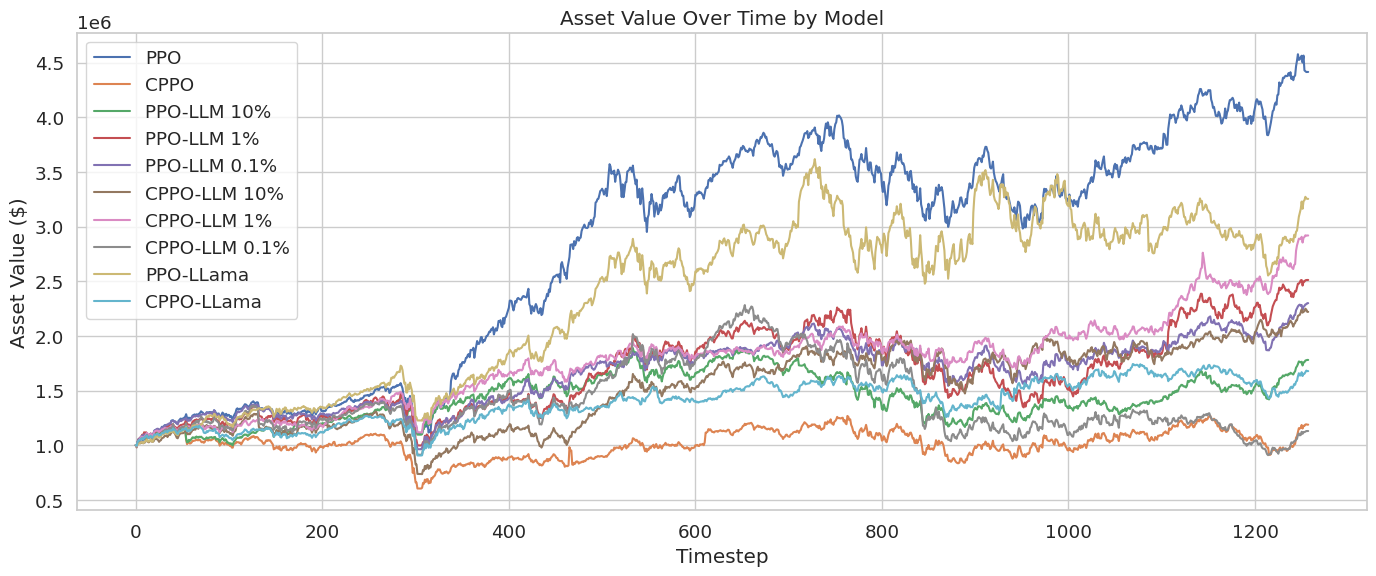

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a dictionary of model names and their asset series
asset_data = {
    "PPO": pd.Series(df_assets_ppo),
    "CPPO": pd.Series(df_assets_cppo),
    "PPO-LLM 10%": pd.Series(df_assets_ppo_llm),
    "PPO-LLM 1%": pd.Series(df_assets_ppo_llm_1),
    "PPO-LLM 0.1%": pd.Series(df_assets_ppo_llm_01),
    "CPPO-LLM 10%": pd.Series(df_assets_cppo_llm_risk),
    "CPPO-LLM 1%": pd.Series(df_assets_cppo_llm_risk_1),
    "CPPO-LLM 0.1%": pd.Series(df_assets_cppo_llm_risk_01),
    "PPO-LLama": pd.Series(df_assets_ppo_llama),
    "CPPO-LLama": pd.Series(df_assets_cppo_llama_risk),
}

# Combine into one DataFrame
df_all_assets = pd.DataFrame(asset_data)

# Plot
plt.figure(figsize=(14, 6))
for column in df_all_assets.columns:
    plt.plot(df_all_assets[column], label=column)

plt.title("Asset Value Over Time by Model")
plt.xlabel("Timestep")
plt.ylabel("Asset Value ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


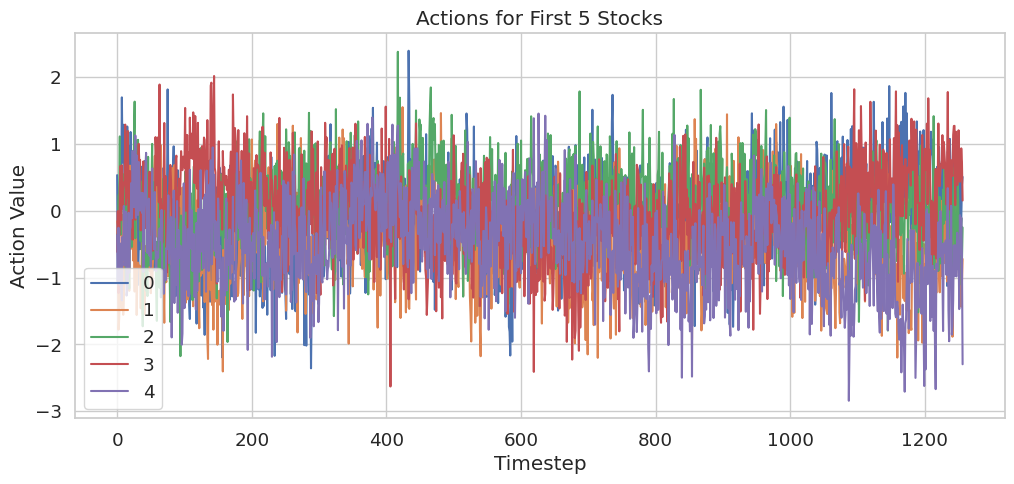

In [ ]:
import numpy as np

# Convert to DataFrame for visualization
actions_array = np.array(df_actions_ppo_llm)
df_actions = pd.DataFrame(actions_array)

# Plot action distribution for a few stocks
df_actions.iloc[:, :5].plot(figsize=(12, 5), title="Actions for First 5 Stocks")
plt.xlabel("Timestep")
plt.ylabel("Action Value")
plt.grid(True)
plt.show()
